In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
permits = pd.read_csv('./datasets/building_permits_2017.csv')
permits.head()

permit_id      issued      cost        lat        lng
0  2017032777  2017-05-24  226201.0  36.198241 -86.742235
1  2017061156  2017-10-23   15000.0  36.151554 -86.830222
2  2017074521  2017-11-20   13389.0  36.034239 -86.708892
3  2017035041  2017-05-30   40000.0  36.128659 -86.841815
4  2017000049  2017-01-09  268107.0  36.045042 -86.616211

In [3]:
council_districts = gpd.read_file('./datasets/council_districts.geojson')[['district','geometry']]
council_districts.head()

district                                           geometry
0        1  (POLYGON ((-86.90738248774342 36.3905151283193...
1        2  (POLYGON ((-86.75902399986667 36.2309080000732...
2        8  (POLYGON ((-86.72850199989709 36.2832840002146...
3        9  (POLYGON ((-86.68680500011935 36.2867050001350...
4        4  (POLYGON ((-86.74488864807594 36.0531632050230...

## Finding counts from a spatial join

In [4]:
# Create a shapely Point from lat and lng
permits['geometry'] = permits.apply(lambda x: Point((x.lng , x.lat)), axis = 1)

# Build a GeoDataFrame: permits_geo
permits_geo = gpd.GeoDataFrame(permits, crs = council_districts.crs, geometry = permits.geometry)

# Spatial join of permits_geo and council_districts
permits_by_district = gpd.sjoin(permits_geo, council_districts, op = 'within')
permits_by_district.head(2)

permit_id      issued      cost        lat        lng  \
0   2017032777  2017-05-24  226201.0  36.198241 -86.742235   
68  2017053890  2017-09-05       0.0  36.185442 -86.768239   

                                geometry  index_right district  
0   POINT (-86.74223499999999 36.198241)            5        5  
68  POINT (-86.76823900000001 36.185442)            5        5

In [5]:
# Create permit_counts
permit_counts = permits_by_district.groupby(['district']).size()
permit_counts.head()

district
1     146
10    119
11    239
12    163
13    139
dtype: int64

## Council district areas and permit counts

In [6]:
# Convert permit_counts to a DataFrame
permits_df = permit_counts.to_frame()
print(permits_df.head(2))

            0
district     
1         146
10        119


In [7]:
# Reset index and column names
permits_df.reset_index(inplace=True)
permits_df.columns = ['district', 'bldg_permits']
print(permits_df.head(2))

  district  bldg_permits
0        1           146
1       10           119


In [8]:
# Merge council_districts and permits_df: 
districts_and_permits = pd.merge(council_districts, permits_df, on = 'district')
districts_and_permits.head(2)

district                                           geometry  bldg_permits
0        1  (POLYGON ((-86.90738248774342 36.3905151283193...           146
1        2  (POLYGON ((-86.75902399986667 36.2309080000732...           399

## Calculating a normalized metric

In [9]:
# Print the type of districts_and_permits and change the area of unit to meters from degrees. 
# To conver meters to kilometers in area, divided by 10**6 to km2 from m2
print(type(districts_and_permits))
districts_and_permits['area'] = districts_and_permits['geometry'].to_crs(epsg = 3857).area / (10**6)
districts_and_permits.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


district                                           geometry  bldg_permits  \
0        1  (POLYGON ((-86.90738248774342 36.3905151283193...           146   
1        2  (POLYGON ((-86.75902399986667 36.2309080000732...           399   
2        8  (POLYGON ((-86.72850199989709 36.2832840002146...           209   
3        9  (POLYGON ((-86.68680500011935 36.2867050001350...           186   
4        4  (POLYGON ((-86.74488864807594 36.0531632050230...           139   

         area  
0  350.194851  
1   44.956987  
2   38.667932  
3   44.295293  
4   31.441618

In [10]:
# Create permit_density column in districts_and_permits
districts_and_permits['permit_density'] = districts_and_permits.apply(lambda row: row.bldg_permits / row.area, axis = 1)

# Print the head of districts_and_permits
districts_and_permits.head()

district                                           geometry  bldg_permits  \
0        1  (POLYGON ((-86.90738248774342 36.3905151283193...           146   
1        2  (POLYGON ((-86.75902399986667 36.2309080000732...           399   
2        8  (POLYGON ((-86.72850199989709 36.2832840002146...           209   
3        9  (POLYGON ((-86.68680500011935 36.2867050001350...           186   
4        4  (POLYGON ((-86.74488864807594 36.0531632050230...           139   

         area  permit_density  
0  350.194851        0.416911  
1   44.956987        8.875150  
2   38.667932        5.404995  
3   44.295293        4.199092  
4   31.441618        4.420892

## Geopandas choropleths

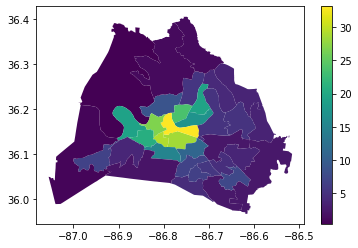

In [11]:
# Simple plot of building permit_density
districts_and_permits.plot(column = 'permit_density', legend = True);
plt.show();

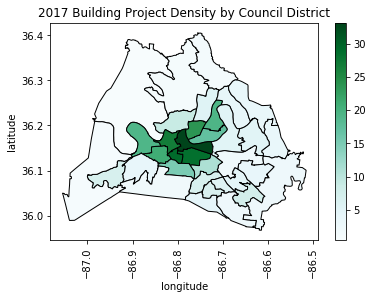

In [12]:
# Polished choropleth of building permit_density
districts_and_permits.plot(column = 'permit_density', cmap = 'BuGn', edgecolor = 'black', legend = True)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xticks(rotation = 'vertical')
plt.title('2017 Building Project Density by Council District')
plt.show();

## Area in km squared, geometry in decimal degrees

In [13]:
# Change council_districts crs to epsg 3857
council_districts = council_districts.to_crs(epsg = 3857)
print(council_districts.crs)
print(council_districts.head())

# Create area in square km
sqm_to_sqkm = 10**6
council_districts['area'] = council_districts.geometry.area / sqm_to_sqkm

# Change council_districts crs back to epsg 4326
council_districts = council_districts.to_crs(epsg = 4326)
print(council_districts.crs)
print(council_districts.head())

{'init': 'epsg:3857', 'no_defs': True}
  district                                           geometry
0        1  (POLYGON ((-9674485.564711858 4354489.55569189...
1        2  (POLYGON ((-9657970.37338656 4332440.649821124...
2        8  (POLYGON ((-9654572.679891953 4339671.15221535...
3        9  (POLYGON ((-9649930.991109086 4340143.58970314...
4        4  (POLYGON ((-9656396.83322303 4307939.01495162,...
{'init': 'epsg:4326', 'no_defs': True}
  district                                           geometry        area
0        1  (POLYGON ((-86.9073824877434 36.39051512831935...  350.194851
1        2  (POLYGON ((-86.75902399986667 36.2309080000731...   44.956987
2        8  (POLYGON ((-86.72850199989709 36.2832840002146...   38.667932
3        9  (POLYGON ((-86.68680500011934 36.2867050001350...   44.295293
4        4  (POLYGON ((-86.74488864807593 36.0531632050230...   31.441618


## Spatially joining and getting counts

In [14]:
# Create permits_geo
permits_geo = gpd.GeoDataFrame(permits, crs = council_districts.crs, geometry = permits.geometry)
permits_geo.head()

permit_id      issued      cost        lat        lng  \
0  2017032777  2017-05-24  226201.0  36.198241 -86.742235   
1  2017061156  2017-10-23   15000.0  36.151554 -86.830222   
2  2017074521  2017-11-20   13389.0  36.034239 -86.708892   
3  2017035041  2017-05-30   40000.0  36.128659 -86.841815   
4  2017000049  2017-01-09  268107.0  36.045042 -86.616211   

                               geometry  
0  POINT (-86.74223499999999 36.198241)  
1  POINT (-86.83022199999999 36.151554)  
2  POINT (-86.70889200000001 36.034239)  
3  POINT (-86.841815 36.12865900000001)  
4  POINT (-86.61621099999999 36.045042)

In [15]:
# Spatially join permits_geo and council_districts
permits_by_district = gpd.sjoin(permits_geo, council_districts, op = 'within')
permits_by_district.head()

permit_id      issued      cost        lat        lng  \
0    2017032777  2017-05-24  226201.0  36.198241 -86.742235   
68   2017053890  2017-09-05       0.0  36.185442 -86.768239   
116  2017047073  2017-08-22  165708.0  36.203964 -86.741792   
152  2016064424  2017-01-11   10000.0  36.196708 -86.774026   
187  2017069196  2017-10-26   80000.0  36.199428 -86.766651   

                                 geometry  index_right district       area  
0    POINT (-86.74223499999999 36.198241)            5        5  19.030612  
68   POINT (-86.76823900000001 36.185442)            5        5  19.030612  
116          POINT (-86.741792 36.203964)            5        5  19.030612  
152  POINT (-86.77402600000001 36.196708)            5        5  19.030612  
187          POINT (-86.766651 36.199428)            5        5  19.030612

In [16]:
# Count permits in each district
permit_counts = permits_by_district.groupby("district").size()

# Convert permit_counts to a df with 2 columns: district and bldg_permits
counts_df = permit_counts.to_frame()
counts_df.reset_index(inplace=True)
counts_df.columns = ['district', 'bldg_permits']
counts_df.head()

district  bldg_permits
0        1           146
1       10           119
2       11           239
3       12           163
4       13           139

## Building a polished Geopandas choropleth

In [17]:
# Merge council_districts and counts_df
districts_and_permits = pd.merge(council_districts, counts_df, on = 'district')
districts_and_permits.head()

district                                           geometry        area  \
0        1  (POLYGON ((-86.9073824877434 36.39051512831935...  350.194851   
1        2  (POLYGON ((-86.75902399986667 36.2309080000731...   44.956987   
2        8  (POLYGON ((-86.72850199989709 36.2832840002146...   38.667932   
3        9  (POLYGON ((-86.68680500011934 36.2867050001350...   44.295293   
4        4  (POLYGON ((-86.74488864807593 36.0531632050230...   31.441618   

   bldg_permits  
0           146  
1           399  
2           209  
3           186  
4           139

In [18]:
# Create permit_density column
districts_and_permits['permit_density'] = districts_and_permits.apply(lambda row: row.bldg_permits / row.area, axis = 1)
districts_and_permits.head()

district                                           geometry        area  \
0        1  (POLYGON ((-86.9073824877434 36.39051512831935...  350.194851   
1        2  (POLYGON ((-86.75902399986667 36.2309080000731...   44.956987   
2        8  (POLYGON ((-86.72850199989709 36.2832840002146...   38.667932   
3        9  (POLYGON ((-86.68680500011934 36.2867050001350...   44.295293   
4        4  (POLYGON ((-86.74488864807593 36.0531632050230...   31.441618   

   bldg_permits  permit_density  
0           146        0.416911  
1           399        8.875150  
2           209        5.404995  
3           186        4.199092  
4           139        4.420892

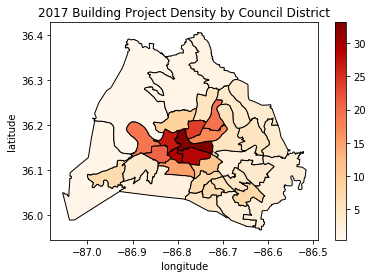

In [19]:
# Create choropleth plot
districts_and_permits.plot(column = 'permit_density', cmap = 'OrRd', edgecolor = 'black', legend = True)

# Add axis labels and title
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('2017 Building Project Density by Council District')
plt.show();

## Folium choropleth

In [20]:
import folium

In [21]:
# Center point for Nashville
nashville = [36.1636,-86.7823]

# Create map
m = folium.Map(location=nashville, zoom_start=10)

In [22]:
# Build choropleth
m.choropleth(
    geo_data=districts_and_permits,
    name='geometry',
    data=districts_and_permits,
    columns=['district', 'permit_density'],
    key_on='feature.properties.district',
    fill_color='Reds',
    fill_opacity=0.5,
    line_opacity=1,
    legend_name='2017 Permitted Building Projects per km squared'
)

/Users/thin.nandar/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [23]:
# Create LayerControl and add it to the map            
folium.LayerControl().add_to(m)

# Display the map
display(m)

## Folium choropleth with markers and popups

In [24]:
districts_and_permits.head()

district                                           geometry        area  \
0        1  (POLYGON ((-86.9073824877434 36.39051512831935...  350.194851   
1        2  (POLYGON ((-86.75902399986667 36.2309080000731...   44.956987   
2        8  (POLYGON ((-86.72850199989709 36.2832840002146...   38.667932   
3        9  (POLYGON ((-86.68680500011934 36.2867050001350...   44.295293   
4        4  (POLYGON ((-86.74488864807593 36.0531632050230...   31.441618   

   bldg_permits  permit_density  
0           146        0.416911  
1           399        8.875150  
2           209        5.404995  
3           186        4.199092  
4           139        4.420892

In [25]:
# Create center column for the centroid of each district
districts_and_permits['center'] = districts_and_permits.geometry.centroid
districts_and_permits.head()

district                                           geometry        area  \
0        1  (POLYGON ((-86.9073824877434 36.39051512831935...  350.194851   
1        2  (POLYGON ((-86.75902399986667 36.2309080000731...   44.956987   
2        8  (POLYGON ((-86.72850199989709 36.2832840002146...   38.667932   
3        9  (POLYGON ((-86.68680500011934 36.2867050001350...   44.295293   
4        4  (POLYGON ((-86.74488864807593 36.0531632050230...   31.441618   

   bldg_permits  permit_density                                        center  
0           146        0.416911  POINT (-86.89459869515021 36.26266635824659)  
1           399        8.875150  POINT (-86.80270842421457 36.20859420830926)  
2           209        5.404995  POINT (-86.73775596834457 36.24515598511001)  
3           186        4.199092  POINT (-86.67436394441584 36.23852818463941)  
4           139        4.420892  POINT (-86.73914087216718 36.02939641896401)

In [40]:
pt = districts_and_permits.center.loc[0]
print(pt)
print(pt.x)

POINT (-86.89459869515021 36.26266635824659)
-86.89459869515021


In [41]:
# Build markers and popups
for row in districts_and_permits.iterrows():
    row_values = row[1]
    center_point = row_values['center']
    location = [center_point.y, center_point.x]
    popup = ('Council District: ' + str(row_values['district']) + 
             ';  ' + 'permits issued: ' + str(row_values['bldg_permits']))
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(m)
    
# Display the map
display(m)